In [317]:
#Import required Libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import tensorflow as tf

In [318]:
from emnist import extract_training_samples, extract_test_samples

#https://pypi.org/project/emnist/
#['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

#Data stats
#https://knowyourdata-tfds.withgoogle.com/#dataset=emnist&tab=STATS&group_by=kyd/emnist/label&select=kyd%2Femnist%2Flabel

type_dataset = 'balanced'

x_train, y_train = extract_training_samples(type_dataset)
x_test, y_test = extract_test_samples(type_dataset)
y_train_classes = y_train


In [319]:
total = x_train.shape[0] + x_test.shape[0]
print("Total #images", total)
print("Total #Train images : ", int(0.8 * x_train.shape[0]))
print("Total #Validation images: ", int(0.2 * x_train.shape[0])) #20% of train dataset
print("Total #Test images : ", x_test.shape[0])
a = round(int(0.8 * x_train.shape[0])/total,2)
b = round(int(0.2 * x_train.shape[0])/total, 2)
c = round(x_test.shape[0]/total,2)
print("Ratio: ",a," : ", b, " : ", c)
width = x_train.shape[1]
height = x_train.shape[2]
print("Image dimension->", " Width: ", width, "\tHeight: ", height)

Total #images 131600
Total #Train images :  90240
Total #Validation images:  22560
Total #Test images :  18800
Ratio:  0.69  :  0.17  :  0.14
Image dimension->  Width:  28 	Height:  28


In [320]:
"""
Q. Why merge some clasees together ?

Ans. This explains that many letters have problems in character recognition that the upper and lower case variants are very similar. 
This causes problems in trying to classify these letters. 
To counteract this they have merged the letters they thought this was a problem for.

The merged classes, as suggested by the NIST, are for the letters C, I, J, K, L, M, O, P, S, U, V, W, X, Y and Z.

"""
# Formulate classlabels list according to dataset selected

import string

lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase

lowercase_list = list(lowercase)
uppercase_list = list(uppercase)

digits = list((range(0,10)))
digits = list(map(str, digits))

merged_letters = ['c', 'i', 'j', 'k', 'l', 'm', 'o', 'p', 's', 'u', 'v', 'w', 'x', 'y' ,'z']

reduced_lowercase_letters = list(set(lowercase_list).difference(merged_letters)) #remove merge class names
reduced_lowercase_letters.sort()

if type_dataset == "byclass":
    classes_names = digits + uppercase_list + lowercase_list
    
if type_dataset == "balanced" or type_dataset == "bymerge":
    classes_names = digits + uppercase_list + reduced_lowercase_letters
    
if type_dataset == "digits":
    classes_names = digits

if type_dataset == "letters":
    classes_names = uppercase_list

if type_dataset == "mnist":
    classes_names = digits

## Data Distribution Visualization

### Train Data Distribution

In [321]:
import pandas as pd

#if 'letters' put k-1
temp_class = [classes_names[k] for k in y_train]

temp_class = sorted(temp_class)
df = pd.DataFrame(temp_class,columns=['Classes'])

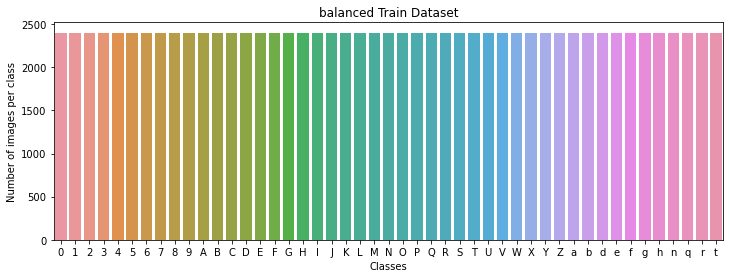

In [322]:
import seaborn as sns
plt.figure(figsize=(12,4))
ax = sns.countplot(x ='Classes', data=df)
ax.set_title(type_dataset+" Train Dataset")
ax.set_ylabel("Number of images per class")
plt.savefig("./data_distribution/"+type_dataset+"_train.png")

### Test Data Distribution

In [323]:
import pandas as pd

temp_class = [classes_names[k] for k in y_test]

temp_class = sorted(temp_class)
df = pd.DataFrame(temp_class,columns=['Classes'])

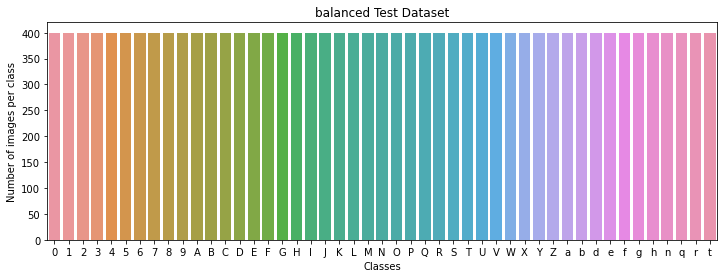

In [324]:
import seaborn as sns
plt.figure(figsize=(12,4))
ax = sns.countplot(x ='Classes', data=df)
ax.set_title(type_dataset+" Test Dataset")
ax.set_ylabel("Number of images per class")
plt.savefig("./data_distribution/"+type_dataset+"_test.png")

## Sample Data Visualization

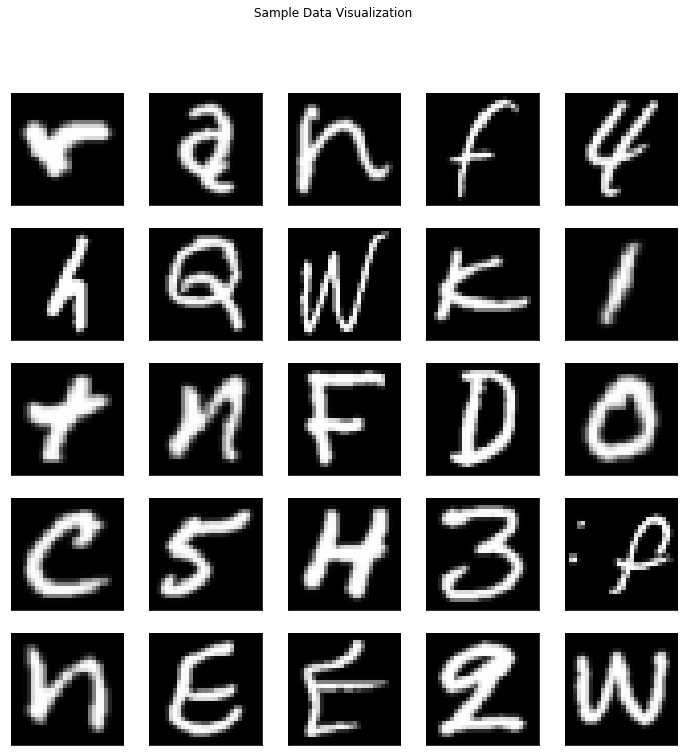

In [325]:
#Printing sample images

fig,axes = plt.subplots(5,5,figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i,ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(x_train[i], cmap='gray')
    plt.suptitle("Sample Data Visualization")

## Preprocess Data

In [326]:
#Normalize the data pixel value between 0..1 currently 0...255

x_train = x_train/255.0
x_test = x_test/255.0

In [327]:
#Reshape the data ( #images x 28 x 28 X 1 )

x_train = x_train.reshape(x_train.shape[0], width, height, 1)

x_test = x_test.reshape(x_test.shape[0], width, height, 1)


In [328]:
#Transform label to one-hot encoding (conversion is important for loss function = "Categorical Crossentropy")
number_of_classes = len(np.unique(y_train))+1

y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

In [329]:
from sklearn.model_selection import train_test_split

# Dividing train data in 80 : 20 = Train : Validation

train_x,test_x,train_y,test_y = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=45)

#Random_state = 45 (used to make sure we get same split everytime. Hence reproducible results)

# Resource : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Model 1 - Simple CNN - 1 Conv Layer 

In [330]:
model1 = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])
model1.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 512)               2769408   
_________________________________________________________________
dense_61 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_62 (Dense)             (None, 48)                6192      
Total params: 2,841,584
Trainable params: 2,841,584
Non-trainable params: 0
___________________________________________

## Model 2 - Complex CNN - 2 Conv Layers

In [331]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten

model2 = Sequential()

model2.add(Conv2D(64, (3,3), input_shape=train_x.shape[1:]))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, (3,3)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())

model2.add(Dense(512))
model2.add(Activation("relu"))

model2.add(Dense(128))
model2.add(Activation("relu"))

model2.add(Dense(number_of_classes))
model2.add(Activation("softmax"))


model2.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
activation_50 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_51 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1600)            

In [332]:
#Select model for training
model = model2

#Parameters for training
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [333]:
#Implement callback functions
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

TB = TensorBoard(log_dir="./logs")
MCP = ModelCheckpoint("./best_models/"+type_dataset+'_best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

2021-12-04 23:27:30.720455: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-04 23:27:30.720474: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-04 23:27:30.720674: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [334]:
#Training the model with parameters and callbacks
batch_size=128
epochs=20
history = model.fit(train_x,train_y ,batch_size=batch_size, epochs=epochs, validation_data=(test_x,test_y), callbacks=[MCP, ES, RLP, TB])

Epoch 1/20
  1/705 [..............................] - ETA: 8:22 - loss: 3.8882 - accuracy: 0.0156

2021-12-04 23:27:31.704134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 23:27:31.849032: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-04 23:27:31.849043: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-04 23:27:31.886760: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-04 23:27:31.887079: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-04 23:27:31.887637: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_12_04_23_27_31

2021-12-04 23:27:31.887999: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_04_23_27_31/Prakhars-MacBook-Air.local.trace.json.gz
2021-12-04 

705/705 [==============================] - ETA: 0s - loss: 0.7957 - accuracy: 0.7544

2021-12-04 23:27:43.908199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


705/705 [==============================] - 14s 19ms/step - loss: 0.7957 - accuracy: 0.7544 - val_loss: 0.4783 - val_accuracy: 0.8342

Epoch 00001: val_accuracy improved from -inf to 0.83422, saving model to ./best_models/balanced_best_points.h5
Epoch 2/20
705/705 [==============================] - 13s 19ms/step - loss: 0.4135 - accuracy: 0.8560 - val_loss: 0.4115 - val_accuracy: 0.8510

Epoch 00002: val_accuracy improved from 0.83422 to 0.85098, saving model to ./best_models/balanced_best_points.h5
Epoch 3/20
705/705 [==============================] - 13s 18ms/step - loss: 0.3461 - accuracy: 0.8752 - val_loss: 0.3750 - val_accuracy: 0.8680

Epoch 00003: val_accuracy improved from 0.85098 to 0.86804, saving model to ./best_models/balanced_best_points.h5
Epoch 4/20
705/705 [==============================] - 13s 18ms/step - loss: 0.3032 - accuracy: 0.8877 - val_loss: 0.3550 - val_accuracy: 0.8721

Epoch 00004: val_accuracy improved from 0.86804 to 0.87207, saving model to ./best_models/ba

In [335]:
#Test Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.38268551230430603
Test accuracy: 0.8829255104064941


# Analysis 

### 1. Classwise Analysis -  Precision/ Recall / F1-score
### 2. Confusion Matrix
### 3. Visualize wrong predicted images
### 4. Activation Layerwise Visualization Analysis

## Classwise Analysis - Precision/ Recall/ F1-score

In [336]:
#Prdicted classes
predict_x_test=model.predict(x_test) 
y_pred_test=np.argmax(predict_x_test,axis=1) 

#Actual classes
y_test_actual = np.argmax(y_test,axis=1) 

2021-12-04 23:41:36.646700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [337]:
#Classification report from SKlearn metrics

from sklearn.metrics import classification_report
print(classification_report(y_test_actual, y_pred_test, target_names=classes_names))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71       400
           1       0.55      0.69      0.62       400
           2       0.92      0.89      0.90       400
           3       0.98      0.97      0.98       400
           4       0.95      0.93      0.94       400
           5       0.95      0.89      0.92       400
           6       0.93      0.93      0.93       400
           7       0.97      0.98      0.97       400
           8       0.94      0.92      0.93       400
           9       0.68      0.85      0.76       400
           A       0.98      0.96      0.97       400
           B       0.97      0.94      0.96       400
           C       0.94      0.96      0.95       400
           D       0.92      0.93      0.92       400
           E       0.98      0.98      0.98       400
           F       0.66      0.64      0.65       400
           G       0.95      0.95      0.95       400
           H       0.96    

## Confusion Matrix

In [338]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_actual,y_pred_test)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


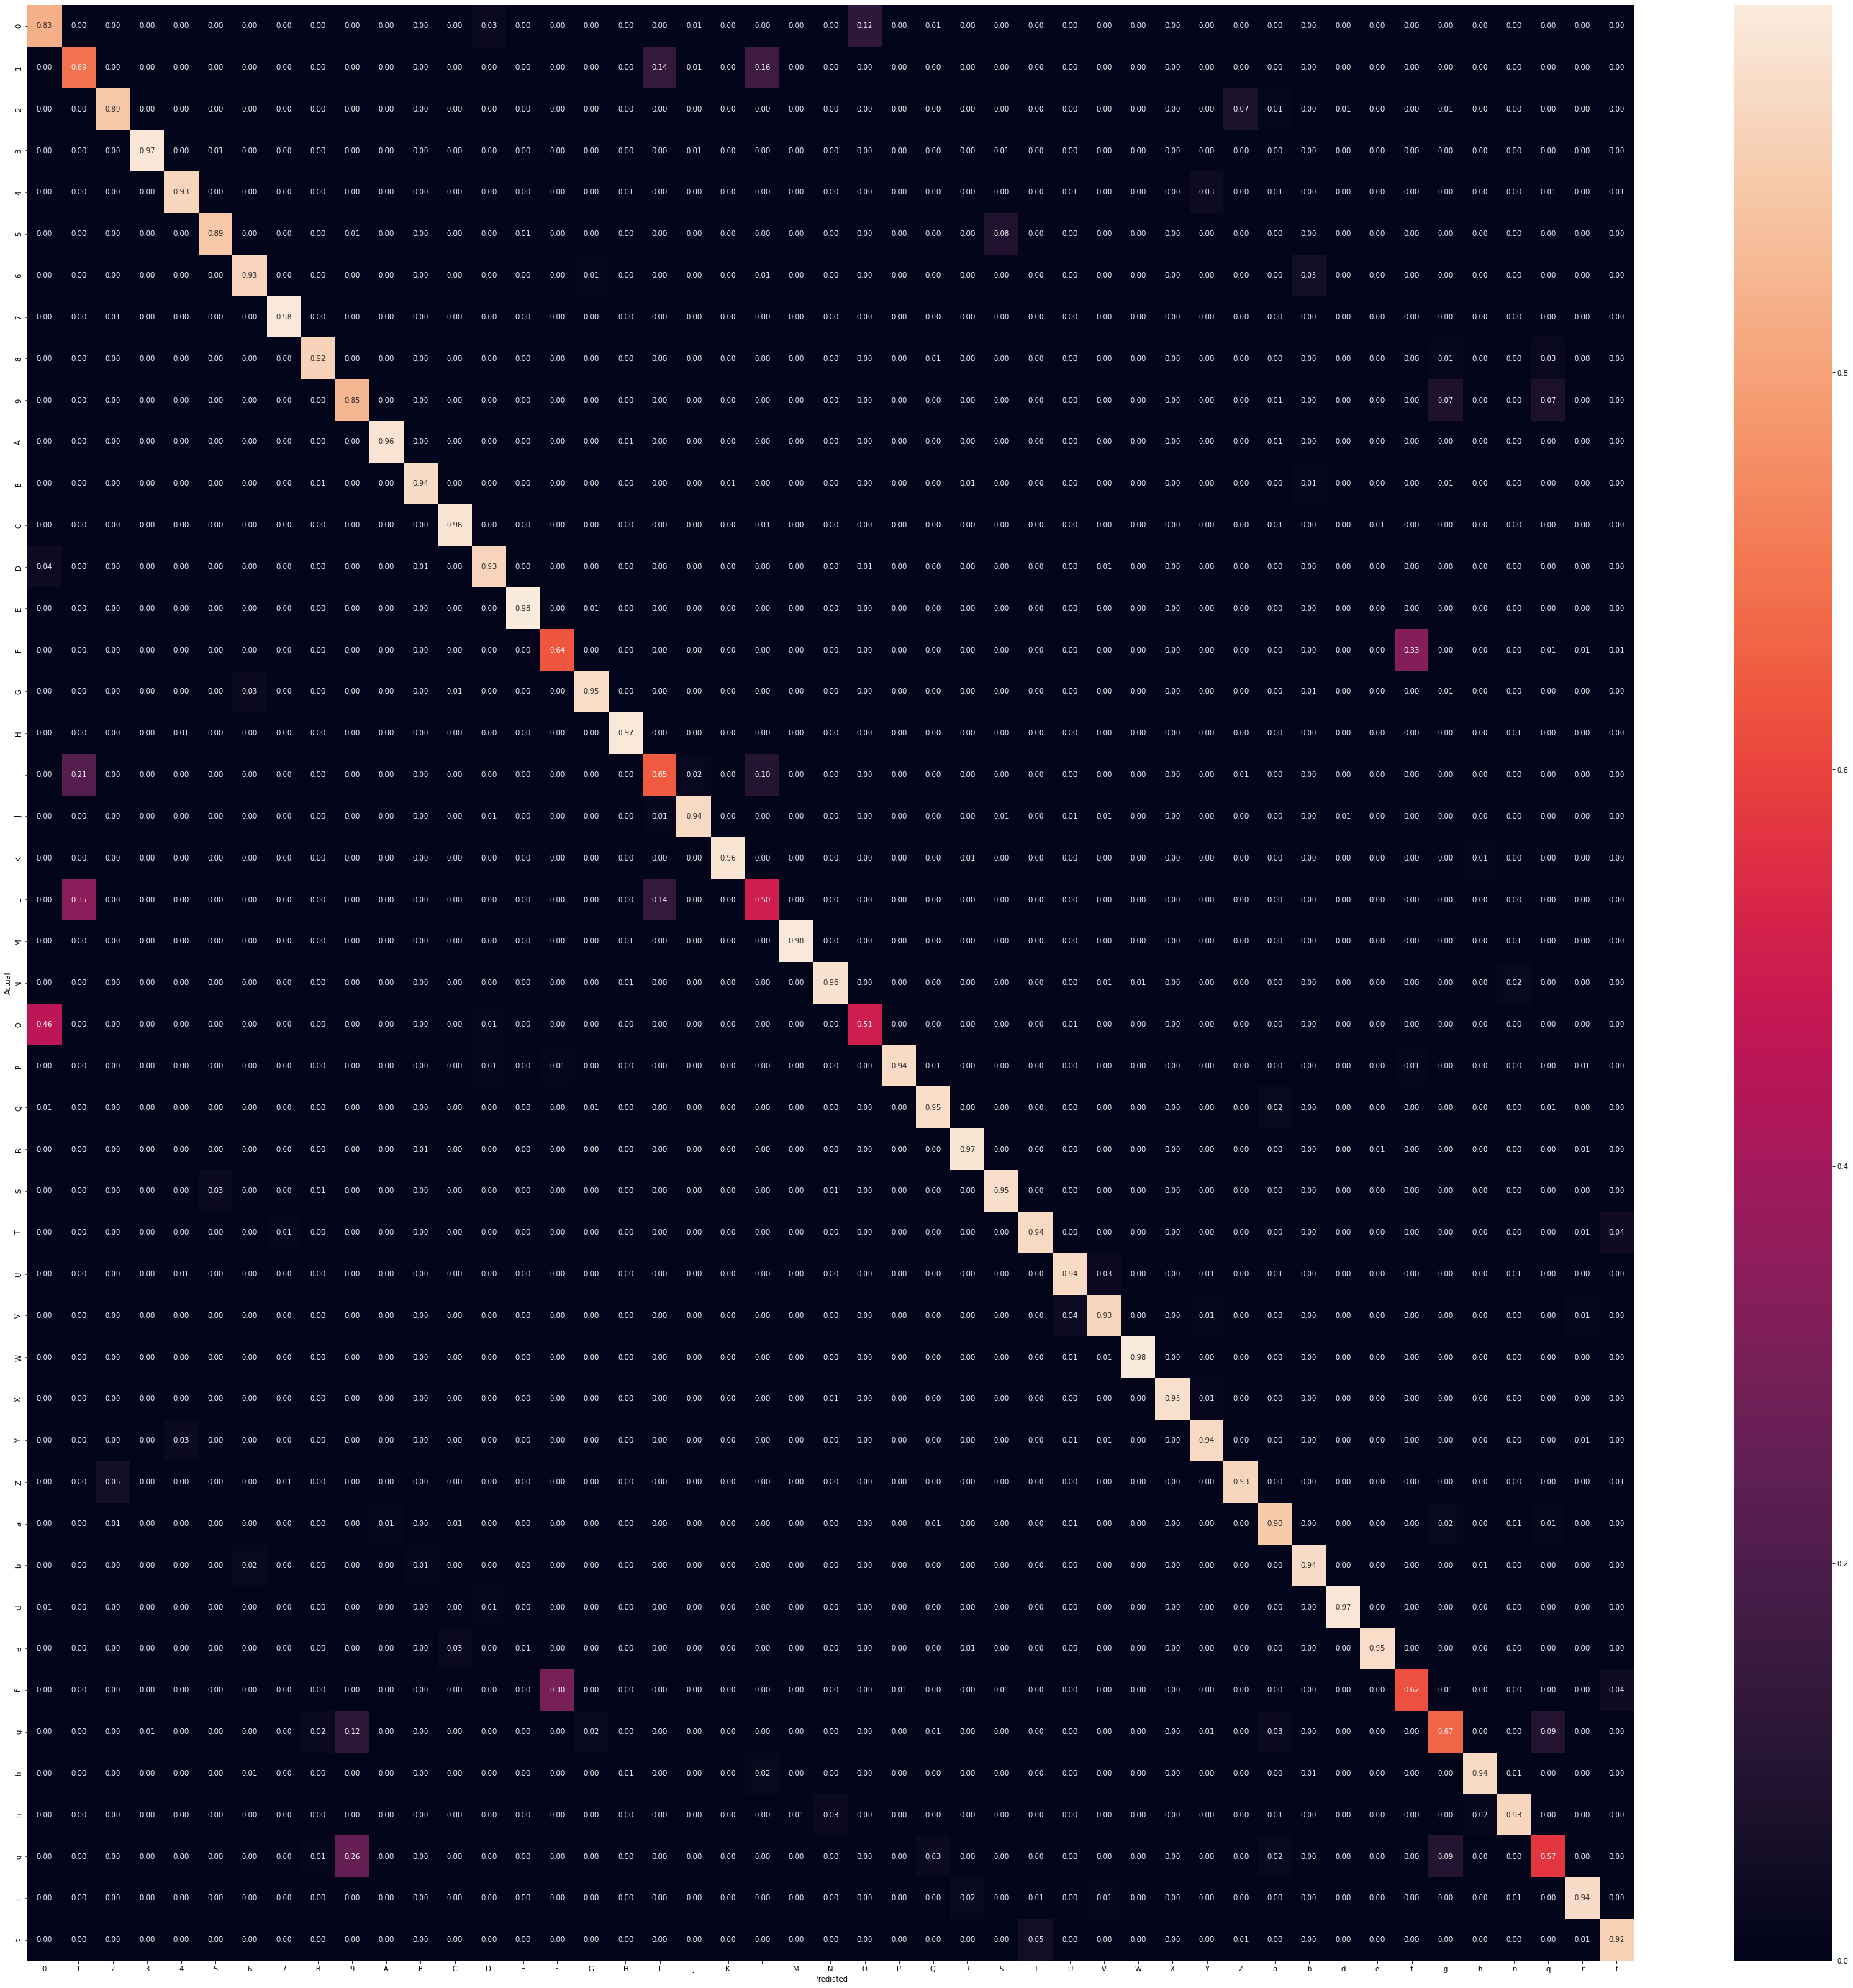

In [339]:
#Visualise confusion matrix using seaborn

import seaborn as sns

df_cm = pd.DataFrame(cmn, index=classes_names, columns=classes_names)

fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(df_cm, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.plot()
#plt.show(block=False)
plt.savefig("./confusion_matrix/"+type_dataset+"_confusion_matrix.png") #save figure locally

## Visualize wrong predicted images

In [340]:
print("Total misclassified images : ", (y_pred_test!=y_test_actual).sum())
indexes_wrong_pred = list(np.where(np.not_equal(y_pred_test, y_test_actual))[0])

Total misclassified images :  2201


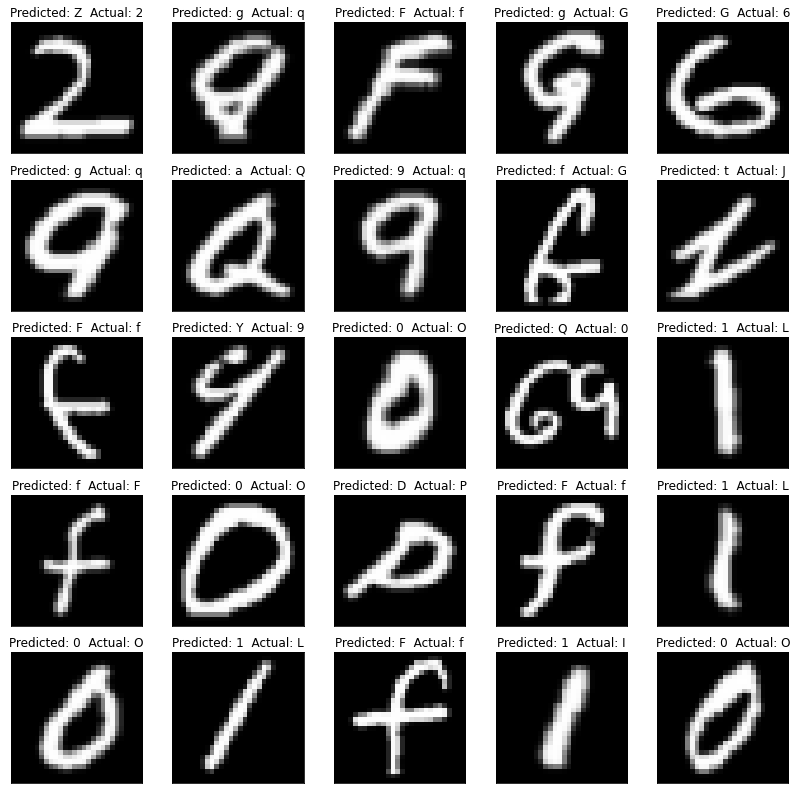

In [341]:
fig,axes = plt.subplots(5,5,figsize=(14,14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i,ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(x_test[indexes_wrong_pred[i]], cmap='gray')
    ax.set_title("Predicted: {0}  Actual: {1}".format(classes_names[y_pred_test[indexes_wrong_pred[i]]],classes_names[y_test_actual[indexes_wrong_pred[i]]]))

## Activation Layerwise Visualization Analysis

In [342]:
slected_img_id = 3 #vary to see different class images feature learnings
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[slected_img_id].reshape(1,28,28,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

2021-12-04 23:41:42.282294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 0.98, 'Selected input image')

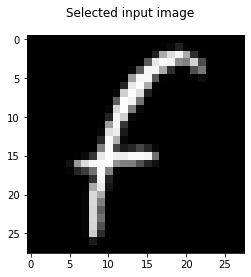

In [343]:
plt.imshow(x_train[slected_img_id],cmap='gray')
plt.suptitle("Selected input image")

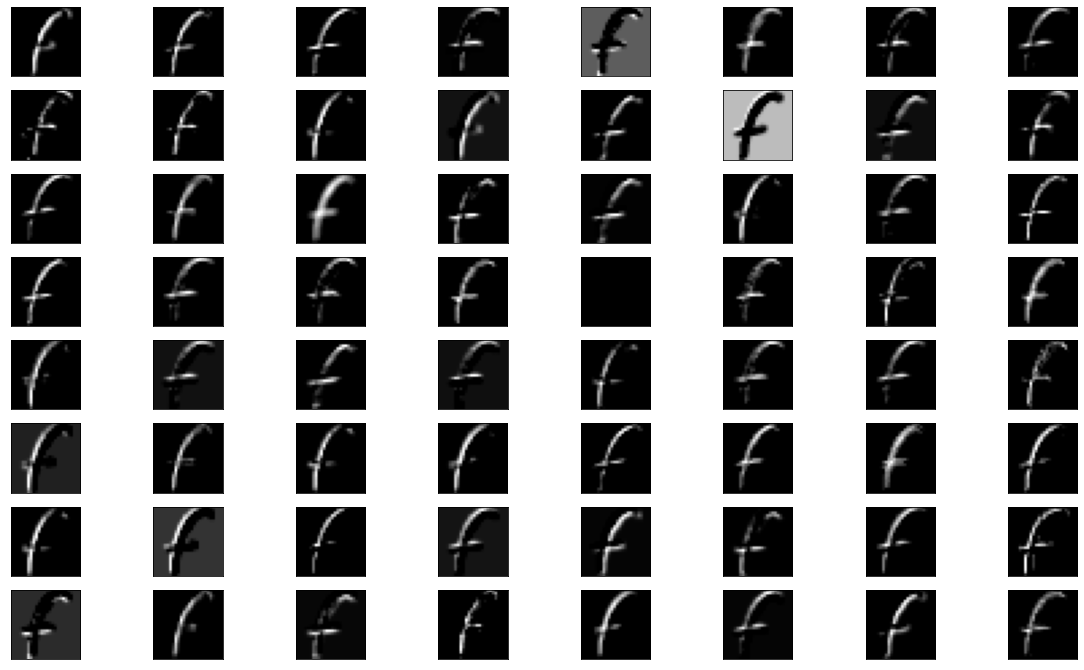

In [344]:
display_activation(activations, 8, 8, 1)

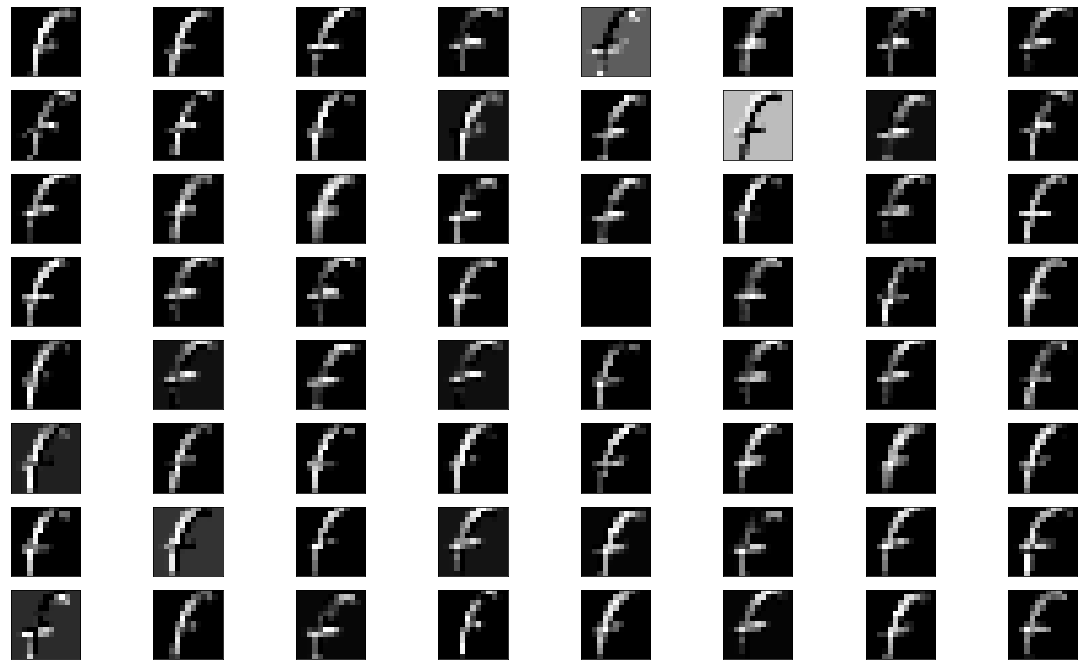

In [345]:
display_activation(activations, 8, 8, 2)

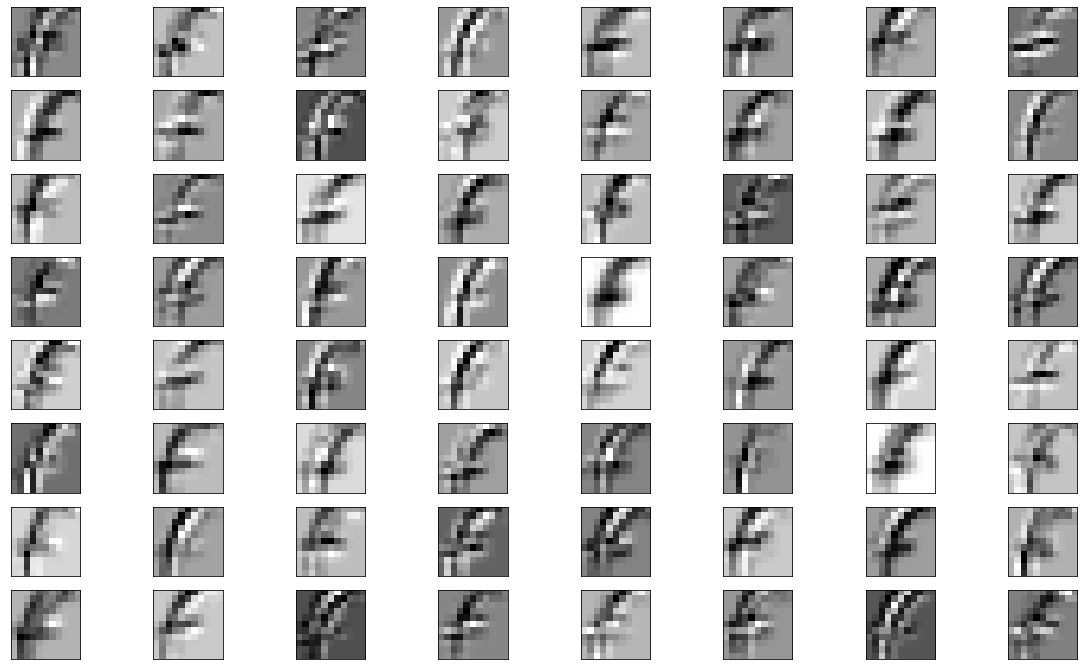

In [346]:
display_activation(activations, 8, 8, 3)

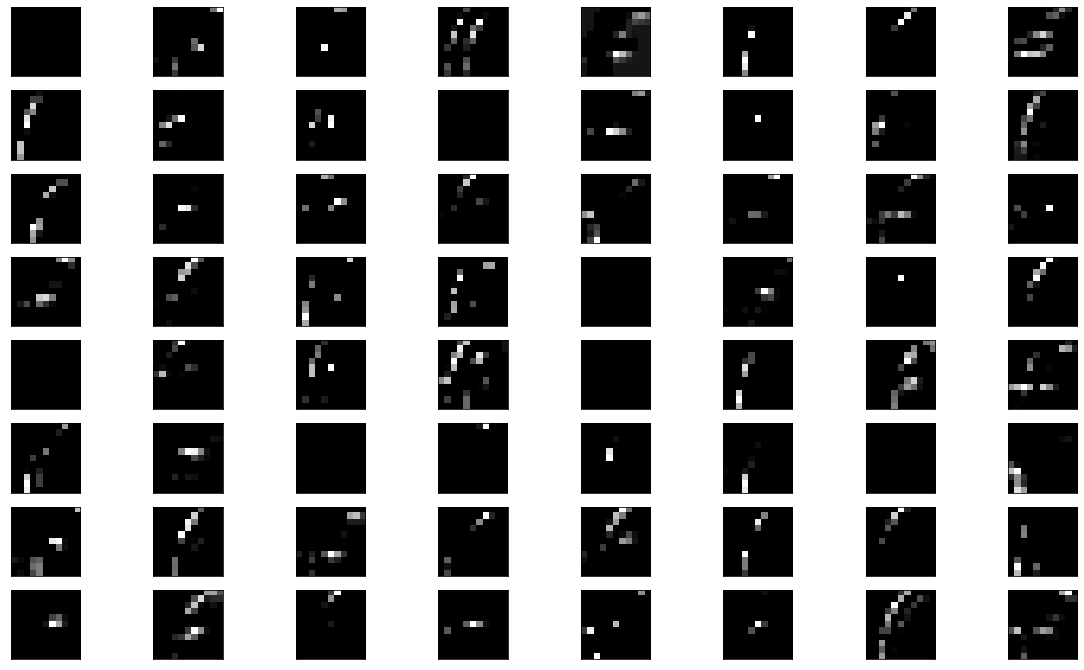

In [347]:
display_activation(activations, 8, 8, 4)

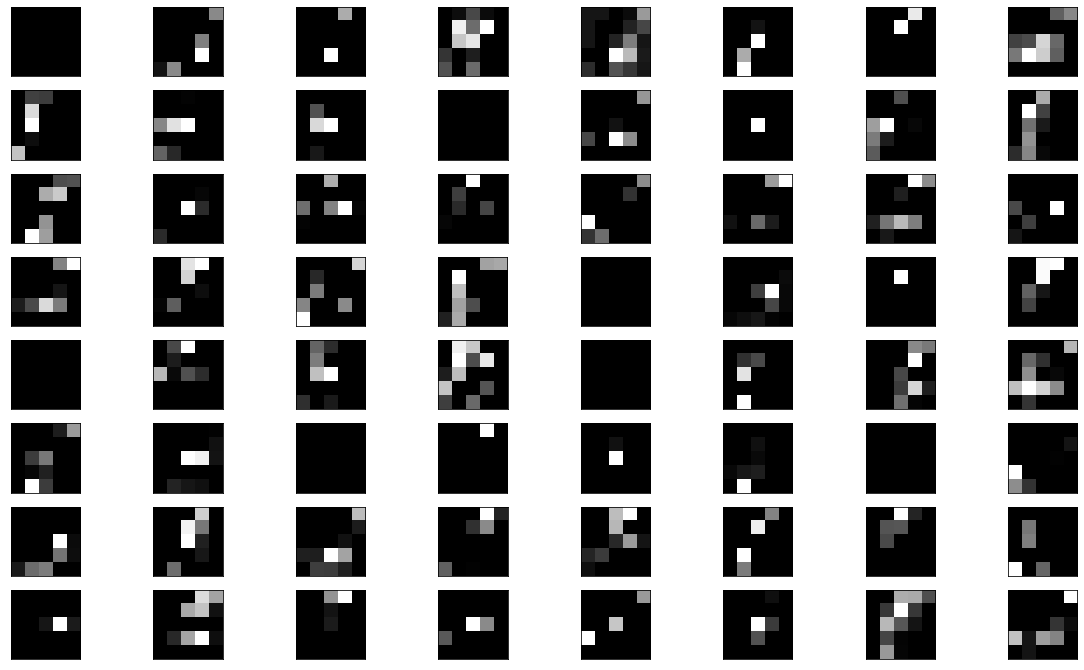

In [348]:
display_activation(activations, 8, 8, 5)

# Evaluate all dataset models

In [349]:
from emnist import extract_test_samples

dataset_list = ['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


for type_dataset in dataset_list:
    #Load Data from emnist pypi
    x_test, y_test = extract_test_samples(type_dataset)


    #prepare data
    x_test = x_test/255.0
    x_test = x_test.reshape(x_test.shape[0], width, height, 1)

    number_of_classes = len(np.unique(y_test))+1
    y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)


    #Evalute the Model

    #Load model for testing
    model_test = tf.keras.models.load_model("./best_models/"+type_dataset+'_best_points.h5')

    score = model_test.evaluate(x_test, y_test, verbose=0)
    print(type_dataset,"Accuracy:", score[1])


2021-12-04 23:41:47.572967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


balanced Accuracy: 0.8829255104064941


2021-12-04 23:41:51.915175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


byclass Accuracy: 0.8646441698074341


2021-12-04 23:42:11.041448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


bymerge Accuracy: 0.9030114412307739


2021-12-04 23:42:29.395351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


digits Accuracy: 0.9956750273704529


2021-12-04 23:42:35.390112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


letters Accuracy: 0.9288942217826843


2021-12-04 23:42:38.340014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


mnist Accuracy: 0.9853000640869141
